<a href="https://colab.research.google.com/github/Leenabh/Python-Data-Visualization/blob/main/FRED_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Get Data

In [ ]:
!pip install full-fred
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.1 MB/s eta 0:00:00


In [ ]:
import os
import openai
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
openai_api_key = 'PUT_UR_API_KEY'

In [ ]:

from urllib.request import urlopen
import json
import pandas as pd 
import urllib.request
data_dir = '/content/drive/MyDrive/w210 capstone/'
#business cycle dates
data_url1 = 'http://data.nber.org/data/cycles/business_cycle_dates.json'

In [ ]:
from full_fred.fred import Fred
fred = Fred(f"{data_dir}FRED_API_KEY.txt")
fred.set_api_key_file(f'{data_dir}FRED_API_KEY.txt')

True

In [ ]:
def build_query(metric_name, geo, data_source=None):
  query = f'What is the Series ID for {metric_name} of {geo} in FRED?'
  if data_source:
    query = f'What is the Series ID for {metric_name} of {geo} in FRED sourced from {data_source}?'
  
  final_query = f"""{query}
  Provide your answer like the following json string: 
  {{"series_id": , 'name': , "data_source": , "frequency": , "observation_start": , "observation_end": , "vintage_data_available": ,
  "seasonally_adjusted": , "units": }}"""
  return final_query 


def fred_data_loader(nl_query):

  gpt_prompt = f"""which economic terms for what geolocation from which data source for what date range in FRED the following sentence is asking? sentence: {nl_query}
  Provide your answer in the following format: {{"name": , "geo_location": , "data_source": , "start_date": , "end_date": }},
  If no relevant information is mentioned, put "NA" in your answer"""
  message = [{"role":"user", "content": gpt_prompt}]
  response = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
      messages = message,
      temperature=0.2,
      max_tokens=200,
      frequency_penalty=0.0
  )
  answer = response.choices[0].message['content']
  answer = answer.replace("'",'"')
  metric = json.loads(answer)
  print(metric)
  gpt_prompt = build_query(metric['name'], metric['geo_location'], metric['data_source'])
  message = [{"role":"user", "content": gpt_prompt}]
  response = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
      messages = message,
      temperature=0.2,
      max_tokens=200,
      frequency_penalty=0.0
  )
  answer = response.choices[0].message['content']
  answer = answer.replace("'",'"')
  df_meta = json.loads(answer)
  if metric["start_date"] != "NA":
    df_meta['observation_start'] = metric['start_date']
  if metric['end_date'] != 'NA':
    df_meta['observation_end'] = metric['end_date']
  print(df_meta)
  df = fred.get_series_df(df_meta['series_id'], observation_start=df_meta['observation_start'],
                          observation_end=df_meta['observation_end'])
  return df, df_meta

def magic_plot(nl_query):
  df, df_meta = fred_data_loader(nl_query)
  fig, ax = plt.subplots(1,1, figsize=(12,8))
  df['value'] = np.round(df['value'].astype(float),2)
  df['date'] = df['date'].astype(np.datetime64)
  ax.plot(df['date'], df['value'])
  ax.legend([df_meta['name']])
  ax.set_title(nl_query)
  ax.set_ylabel(df_meta['units'])
  return df, df_meta


{'name': 'Consumer Price Index', 'geo_location': 'Japan', 'data_source': 'FRED', 'start_date': '2011-01-01', 'end_date': '2021-01-01'}
{'series_id': 'JPNCPIALLMINMEI', 'name': 'Consumer Price Index: All Items for Japan', 'data_source': 'FRED', 'frequency': 'Monthly', 'observation_start': '2011-01-01', 'observation_end': '2021-01-01', 'vintage_data_available': True, 'seasonally_adjusted': True, 'units': 'Index 2015=100'}


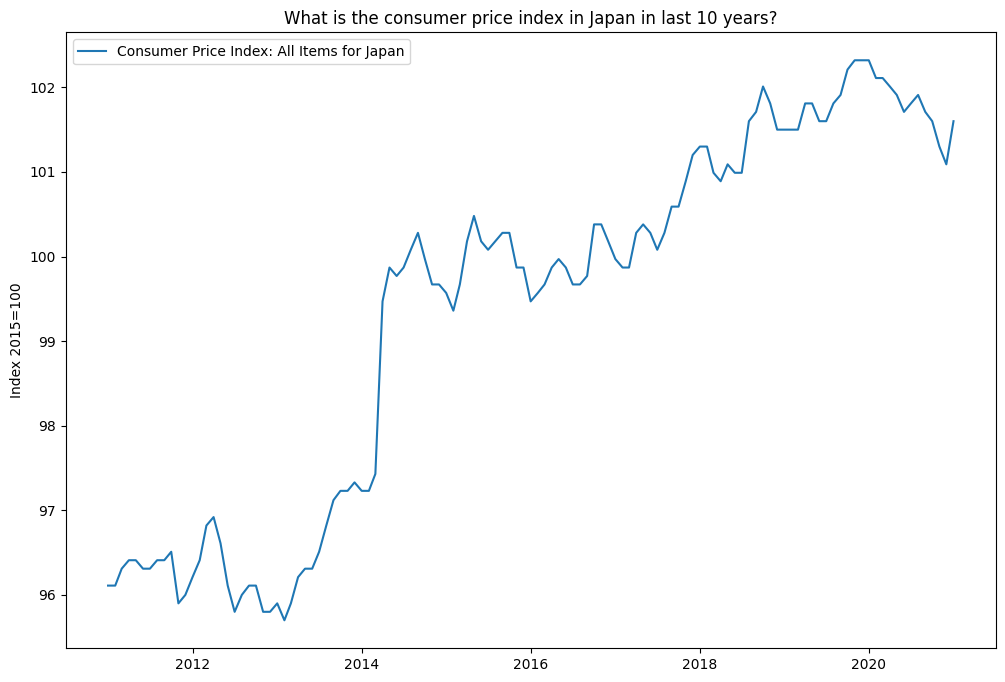

In [ ]:
bbvnl_query = "What is the consumer price index in Japan in last 10 years?"
data, meta = magic_plot(nl_query)

In [ ]:
meta

{'series_id': 'LRHUTTTTJPM156S',
 'name': 'Unemployment Rate: Aged 15-74: All Persons for Japan',
 'data_source': 'OECD',
 'frequency': 'Quarterly',
 'observation_start': '2011-01-01',
 'observation_end': '2021-01-01',
 'vintage_data_available': True,
 'seasonally_adjusted': True,
 'units': 'Percent'}

{'name': 'unemployment', 'geo_location': 'Japan', 'data_source': 'OECD', 'start_date': '2011-01-01', 'end_date': '2021-01-01'}
{'series_id': 'LRHUTTTTJPM156S', 'name': 'Unemployment Rate: Aged 15-74: All Persons for Japan', 'data_source': 'OECD', 'frequency': 'Quarterly', 'observation_start': '2011-01-01', 'observation_end': '2021-01-01', 'vintage_data_available': True, 'seasonally_adjusted': True, 'units': 'Percent'}


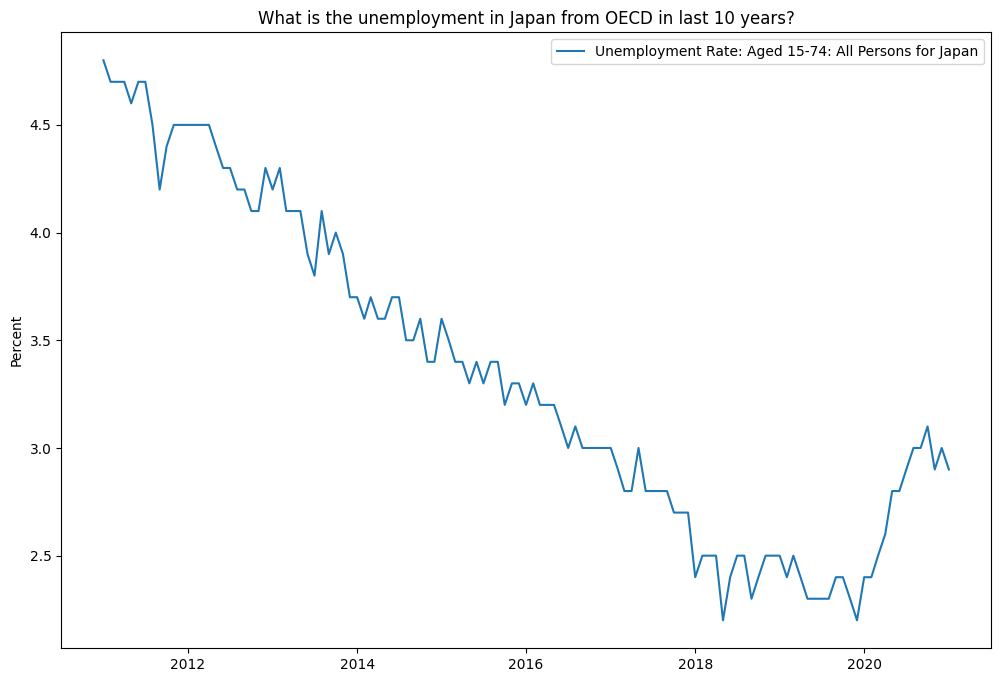

In [ ]:
nl_query = "What is the unemployment in Japan from OECD in last 10 years?"
data, meta = magic_plot(nl_query)

In [ ]:
nl_query = "What is the GDP of China in last 10 years?"
# data, meta = magic_plot(nl_query)

{'name': 'Unemployment Rate', 'geo_location': 'USA', 'data_source': 'FRED', 'start_date': '2011-01-01', 'end_date': '2021-01-01'}
{'series_id': 'UNRATE', 'name': 'Unemployment Rate', 'data_source': 'FRED', 'frequency': 'Monthly', 'observation_start': '2011-01-01', 'observation_end': '2021-01-01', 'vintage_data_available': True, 'seasonally_adjusted': True, 'units': 'Percent'}


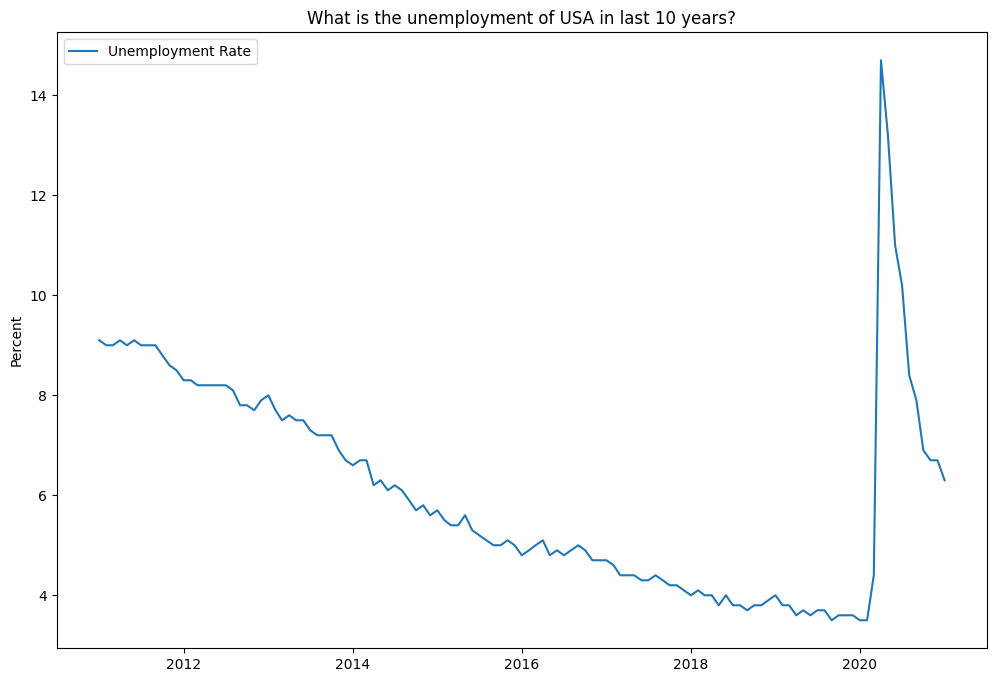

In [ ]:
nl_query = "What is the unemployment of USA in last 10 years?"
data, meta = magic_plot(nl_query)

{'name': 'Average Hourly Earnings', 'geo_location': 'California', 'data_source': 'U.S. Bureau of Labor Statistics', 'start_date': '2011-01-01', 'end_date': '2021-01-01'}
{'series_id': 'SMU06000008000000011', 'name': 'Average Hourly Earnings of All Employees: Total Private in California', 'data_source': 'U.S. Bureau of Labor Statistics', 'frequency': 'Monthly', 'observation_start': '2011-01-01', 'observation_end': '2021-01-01', 'vintage_data_available': True, 'seasonally_adjusted': True, 'units': 'USD'}


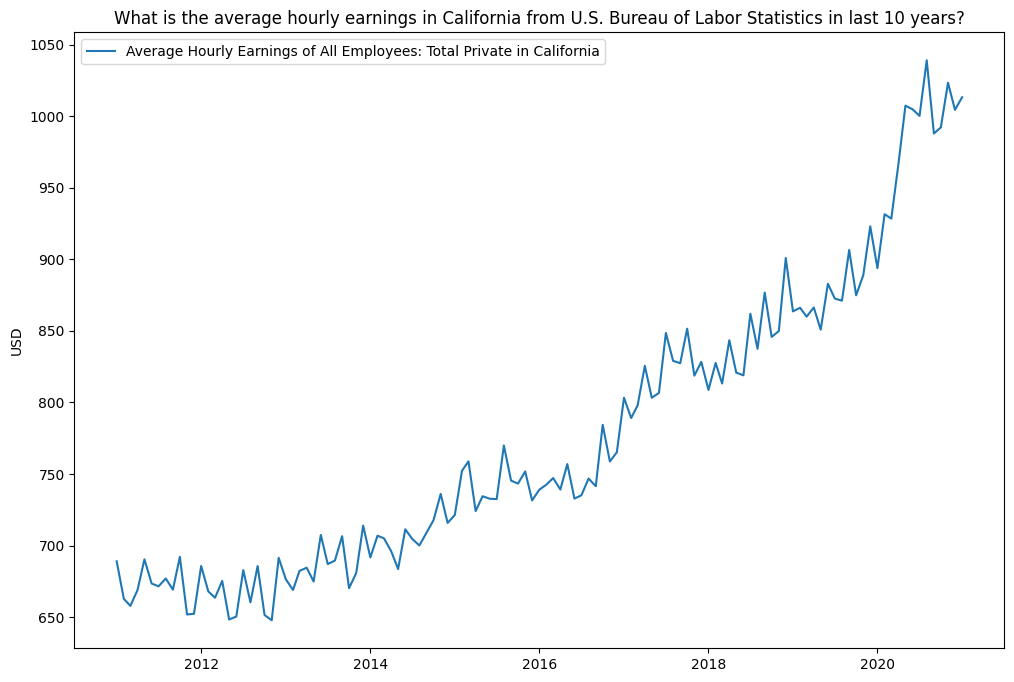

In [ ]:
nl_query = "What is the average hourly earnings in California from U.S. Bureau of Labor Statistics in last 10 years?"
data, meta = magic_plot(nl_query)

In [ ]:
#metric name: inflation: no, CPI: yes. unemployment rate: no, unemployment: yes, hourly wage: no, average hourly eranings: yes
#data source acronym to accurate instituiton
#multiple series query
#how to handle errors
#interaction: follow up questions with different input parameters

#target chart

In [ ]:
fred.get_series_stack()
